In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
from keras.callbacks import *
import math

import random

from dataset import atti_dirigenti

# to make the experimens replicable
random.seed(123456)

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load the Dataset

In [33]:
num_words = 10000
remove_stopwords= True
skip_top = False

In [2]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = atti_dirigenti.load_data(num_words=num_words, remove_stopwords=True)

In [3]:
label_index = atti_dirigenti.get_labels()
len(label_index)

20

In [34]:
most_common = atti_dirigenti.get_most_common_words()
word_index = atti_dirigenti.get_word_index()
stop_words = atti_dirigenti.get_stopwords()

if remove_stopwords:
    most_common = [(k,v) for k,v in most_common if k not in stop_words]

if skip_top > 0:
    most_common = most_common[skip_top:]

#take only the top k words
if num_words:
    most_common=most_common[:num_words]


most_common_selected = set([k for k,v in most_common])

index_word_selected = { word_index[w]:w for w in most_common_selected}

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [4]:
from keras.preprocessing import sequence

In [5]:
print('max length of objects {}'.format(max(map(len, x_train))))

max length of objects 90


#### Maximum Sequence Length

for initial test we use the first 100 words

In [6]:
maxlen = 100

In [7]:
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen)

In [8]:
x_train_seq.shape

(99390, 100)

One-hot encoding for input

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [10]:
dimension = 11000

In [11]:
x_train_vect = vectorize_sequences(x_train, dimension)
x_val_vect = vectorize_sequences(x_val, dimension)
x_test_vect = vectorize_sequences(x_test, dimension)

One hot encoding for the labels

In [12]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [13]:
y_train_vect = to_one_hot(y_train)
y_val_vect = to_one_hot(y_val)
y_test_vect = to_one_hot(y_test)

In [14]:
y_train_vect

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Load pretrained embeddings

In [15]:
from gensim.models import KeyedVectors

In [16]:
path = '../../cc.it.300.vec/data'
fast_text_emb = KeyedVectors.load_word2vec_format(path, binary=False)

In [19]:
len(fast_test_emb.get_vector('acquisto'))

300

In [20]:
embed_size = 300

In [54]:
embed_matrix = np.zeros((dimension + 1, 300))
for i, word in index_word_selected.items():
    if word in fast_text_emb.vocab:
        embedding_vector = fast_text_emb.get_vector(word)
        embed_matrix[i] = embedding_vector

## The Effects of Word Embeddings

Before using a word embedding as a layer in our network let evaluate the effect of embeddings by training a simple classifier that has it as only layer.

In [59]:
def build_model_only_embeddings(embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(
        input_dim=dimension + 1, 
        output_dim=embed_size, 
        weights=[embed_matrix],
        input_length=maxlen,
        trainable=False
    ))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(label_index), activation='softmax', name='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [64]:
model= build_model_only_embeddings(300)

In [65]:
history = model.fit(x=x_train_seq, y=y_train_vect, validation_data=(x_val_seq, y_val_vect),
                   epochs=20, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/20
99390/99390 [==============================] - 2s 24us/step - loss: 2.1649 - acc: 0.3956 - val_loss: 1.8609 - val_acc: 0.4805
Epoch 2/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.7050 - acc: 0.5203 - val_loss: 1.6592 - val_acc: 0.5245
Epoch 3/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.5239 - acc: 0.5656 - val_loss: 1.5504 - val_acc: 0.5486
Epoch 4/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.4093 - acc: 0.5957 - val_loss: 1.4784 - val_acc: 0.5645
Epoch 5/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.3263 - acc: 0.6166 - val_loss: 1.4259 - val_acc: 0.5776
Epoch 6/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.2615 - acc: 0.6331 - val_loss: 1.3873 - val_acc: 0.5866
Epoch 7/20
99390/99390 [==============================] - 2s 22us/step - loss: 1.2091 - acc: 0.6465 - val_loss: 1.3577 - val_acc

In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2.2, step=0.2))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

In [68]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1.05, step=0.05))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

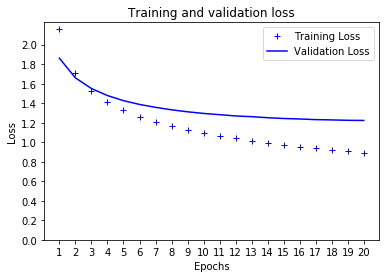

In [70]:
chart_loss(history)

We can see how the model with larger embedding size tend to overfit faster than the others (respectively epochs 2, 3, and 4). However, from a loss point of view all the models starts overfitting with a loss values ~ 0.8.
Let's now analyze values for accuracy.

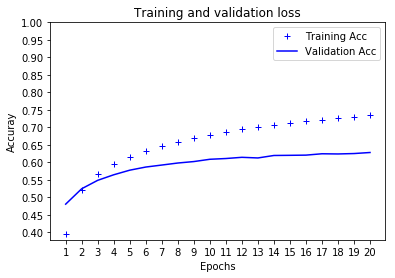

In [71]:
chart_acc(history)

In [72]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1 

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch - 1]

In [74]:
print('min loss for model is {}'.format(min_loss(history)))

min loss for model is 20


In [75]:
print('best validation accuracy for model is {}'.format(
    accuracy(history, min_loss(history))))

best validation accuracy for model is 0.6281238682068849


The results show how only using an flat classifier with an embedding layer we obtain an accuracy 0.82. Which is a pretty good result.
The next steps is use an embedding layers in a Feed Forward Neural Network.

## Build the Models

We take into account:
- a base model that uses dropout
- a embed model that adds an embedding layer

In [84]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train_vect.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [80]:
def build_model_embeddings(neurons):
    model = models.Sequential()
    model.add(layers.Embedding(
        input_dim=dimension + 1, 
        output_dim=embed_size, 
        weights=[embed_matrix],
        input_length=maxlen,
        trainable=False
    ))
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(label_index), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [85]:
model_dropout = build_model_dropout(64)

In [86]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                704064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1300      
Total para

In [87]:
history_dropout = model_dropout.fit(x=x_train_vect, y=y_train_vect, validation_data=(x_val_vect, y_val_vect),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 4s 39us/step - loss: 2.0056 - acc: 0.3725 - val_loss: 1.0783 - val_acc: 0.6496
Epoch 2/10
99390/99390 [==============================] - 3s 29us/step - loss: 1.2334 - acc: 0.5941 - val_loss: 0.8337 - val_acc: 0.7189
Epoch 3/10
99390/99390 [==============================] - 3s 31us/step - loss: 1.0286 - acc: 0.6563 - val_loss: 0.7370 - val_acc: 0.7521
Epoch 4/10
99390/99390 [==============================] - 3s 29us/step - loss: 0.9125 - acc: 0.6935 - val_loss: 0.6921 - val_acc: 0.7687
Epoch 5/10
99390/99390 [==============================] - 3s 29us/step - loss: 0.8523 - acc: 0.7133 - val_loss: 0.6601 - val_acc: 0.7792
Epoch 6/10
99390/99390 [==============================] - 3s 30us/step - loss: 0.7956 - acc: 0.7323 - val_loss: 0.6387 - val_acc: 0.7840
Epoch 7/10
99390/99390 [==============================] - 3s 29us/step - loss: 0.7603 - acc: 0.7452 - val_loss: 0.6223 - val_acc

In [88]:
model_embed = build_model_embeddings(64)

In [89]:
model_embed.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          3300300   
_________________________________________________________________
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                1920064   
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                1300      
Total para

In [90]:
history_embed = model_embed.fit(x=x_train_seq, y=y_train_vect, validation_data=(x_val_seq, y_val_vect),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 4s 43us/step - loss: 2.0317 - acc: 0.3879 - val_loss: 1.5114 - val_acc: 0.5281
Epoch 2/10
99390/99390 [==============================] - 4s 41us/step - loss: 1.4582 - acc: 0.5374 - val_loss: 1.3105 - val_acc: 0.5765
Epoch 3/10
99390/99390 [==============================] - 4s 39us/step - loss: 1.2602 - acc: 0.5922 - val_loss: 1.2361 - val_acc: 0.6052
Epoch 4/10
99390/99390 [==============================] - 4s 39us/step - loss: 1.1400 - acc: 0.6279 - val_loss: 1.1945 - val_acc: 0.6156
Epoch 5/10
99390/99390 [==============================] - 4s 40us/step - loss: 1.0561 - acc: 0.6551 - val_loss: 1.1730 - val_acc: 0.6269
Epoch 6/10
99390/99390 [==============================] - 4s 39us/step - loss: 0.9868 - acc: 0.6753 - val_loss: 1.1727 - val_acc: 0.6307
Epoch 7/10
99390/99390 [==============================] - 4s 39us/step - loss: 0.9274 - acc: 0.6919 - val_loss: 1.1771 - val_acc

### Printing The Loss

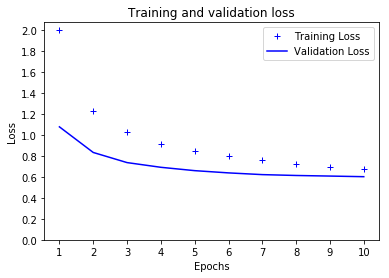

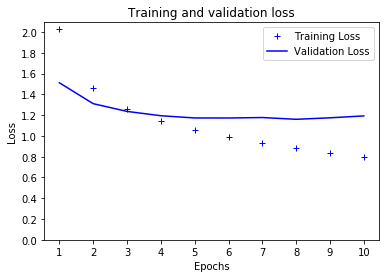

In [91]:
chart_loss(history_dropout)
chart_loss(history_embed)

From the charts we can see that: 
- word embedding seems to not improve the accuracy of the model. This is usual in the case you have little training data available. From another point of view it is surprising to see that the classifier with only an embedding layer perform better than the one taken into account here
- the model with dropout perform better than the model with embeddings.

From this result one could gather that embeddings are not useful. This is wrong, because we didn't consider that we changed another thing with the current represantion. The model that uses embedding takes as input sequence of ids and not a vectorize representation of subjects. 

In the next post we will explore the usage of LSTM to address this kind of representation. 

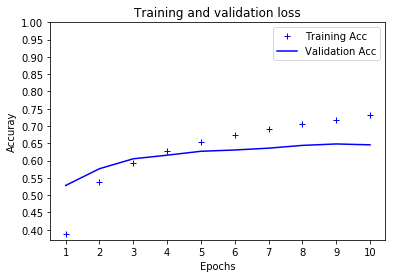

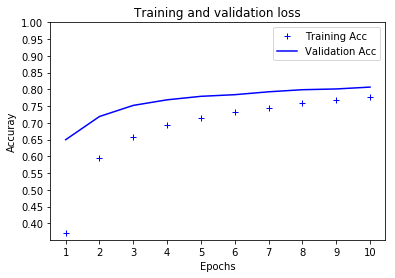

In [92]:
chart_acc(history_embed)
chart_acc(history_dropout)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [93]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

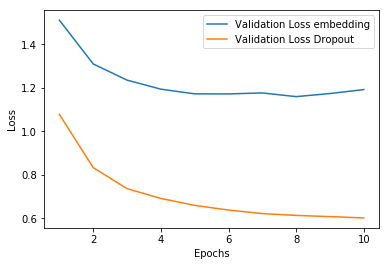

In [94]:
compare_loss({'embedding': history_embed, 'Dropout': history_dropout})

Another interesting factor is that the loss of the model that uses embeddings grows during the training. It shows that embedding trained with the model aren't useful.
Another approach can be uses:
- pretrained embeddings
- remove some of the most frequent words

In [95]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

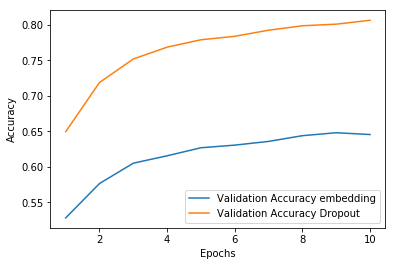

In [96]:
compare_accuracy({'embedding': history_embed, 'Dropout': history_dropout})

In [97]:
print('min loss for model Embed {}'.format(min_loss(history_embed)))
print('min loss for model Dropout is {}'.format(min_loss(history_dropout)))

min loss for model Embed 8
min loss for model Dropout is 10


In [98]:
print('best validation accuracy for model Embed {}'.format(
    accuracy(history_embed, min_loss(history_embed))))
print('best validation accuracy for model Dropout {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))

best validation accuracy for model Embed 0.6439695763268448
best validation accuracy for model Dropout 0.8066823614200618


### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [101]:
model = build_model_embeddings(64)

In [102]:
history = model.fit(x=np.concatenate([x_train_seq, x_val_seq]), y=np.concatenate([y_train_vect, y_val_vect]), epochs=8, batch_size=256)

Epoch 1/8
110434/110434 [==============================] - 4s 41us/step - loss: 1.9767 - acc: 0.4007
Epoch 2/8
110434/110434 [==============================] - 4s 38us/step - loss: 1.4225 - acc: 0.5468
Epoch 3/8
110434/110434 [==============================] - 4s 38us/step - loss: 1.2441 - acc: 0.5963
Epoch 4/8
110434/110434 [==============================] - 4s 38us/step - loss: 1.1316 - acc: 0.6308
Epoch 5/8
110434/110434 [==============================] - 4s 38us/step - loss: 1.0523 - acc: 0.6538
Epoch 6/8
110434/110434 [==============================] - 4s 38us/step - loss: 0.9882 - acc: 0.6736
Epoch 7/8
110434/110434 [==============================] - 4s 38us/step - loss: 0.9338 - acc: 0.6884
Epoch 8/8
110434/110434 [==============================] - 4s 38us/step - loss: 0.8906 - acc: 0.7034


In [103]:
loss, acc = model.evaluate(x_test_seq, y_test_vect)

27609/27609 [==============================] - 1s 47us/step


In [104]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 1.1326746919455724
acc 0.6474338078378806


## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
